# NLP From Scratch: Translation with a Sequence to Sequence Network and Attention

Based on the tutorial: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

The prediction is done by passing the text as a tensor to the encoder model, which outputs an encoded version of the text along with a hidden tensor. This encoded text and hidden tensor are then passed to the decoder model, which iterates for `MAX_LENGTH` iterations (the maximum number of tokens allowed in the sentences). The decoder starts with an `SOS` token and uses the encoder outputs along with the hidden tensor to generate the next token, updating the hidden tensor at each step, until the `EOS` token is found.

The manager expects a single model to run, so this encode-decode step was included in a new model class, `EncoderDecoder`, which has the encoder and decoder classes as attributes.

The manager also expects a single optimizer, so it uses an optimizer chain with the encoder and decoder optimizers (`OptimizerChain([encoder_optimizer, decoder_optimizer])`).

This notebook uses `Teacher forcing` as in the original tutorial (can be disabled by setting `TEACHER_TRAINING = False`). Teacher forcing is the concept of using the real target outputs as each next input, instead of using the decoder's guess as the next input. Using teacher forcing causes it to converge faster but [when the trained network is exploited, it may exhibit instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

Due to teacher forcing, the model expects not only the input but also the target. The manager executes the model by passing only the input (because the target should not be passed by default). To allow teacher forcing, a collate function `collate_fn_teacher` is defined and passed to the dataloader when `TEACHER_TRAINING = True`. This function defines the input as a batch in which each item is a tuple of the original text tensor and the target tensor. A custom executor `TeacherBatchExecutor` processes this input, converting the list of tuples to a tuple of lists corresponding to the input and target, and sends them to the model.

*Important:* The executor expects a batch in which each item in the input corresponds to a record in the dataset. So, a list of tuples `(text, target)` is allowed, but not a tuple of lists `(text[], target[])`. The executor may perform this conversion if necessary (as done in `TeacherBatchExecutor`).

An accuracy calculator class was defined to calculate the mean accuracy of the number of correct tokens compared to the total. A more precise accuracy could be calculated by considering, for each record in the batch, only the elements up to the first `EOS` token in the prediction/target pair where the `EOS` token is more distant (for example, if the first `EOS` token in the predicted output is at position 5 and in the target is at position 7, it should consider only up to position 7 to calculate the accuracy). The current method in this notebook may give a higher accuracy than it should due to the `EOS` tokens at the end of the texts, but it still provides good information about the model's performance.

A custom evaluator `MyEvaluator` was created based on the `evaluate` function of the original tutorial. It behaves almost the same as the `EncoderDecoder` model but also returns the attention (which is plotted at the end of the notebook). If the attentions were not needed, it could call the `EncoderDecoder` model directly and convert the output tensor to the predicted text based on the tokens defined in the output.

In [1]:
LANG1 = 'eng'
LANG2 = 'fra'
REVERSE = True
SUFFIX = f'{LANG1}-{LANG2}' if not REVERSE else f'{LANG2}-{LANG1}'
NAME = f'seq2seq_translation-{SUFFIX}'
SAVE_PATH = f'data/test/train/{NAME}-checkpoint.pth'
REPORT_PATH = f'data/test/train/{NAME}-report.pdf'
DATA_PATH = 'data/char_rnn'
RANDOM_SEED = 0
MAX_LENGTH = 10
USE_ATTENTION = True
TEACHER_TRAINING = True

In [2]:
import sys
if "../" not in sys.path:
  sys.path.append("../")

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
import random
import torch
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading data files

In [6]:
from auto_mind.supervised.data import SplitData
from src.datasets.translation_data import TranslationData

data = TranslationData(
    root_path=DATA_PATH,
    lang1=LANG1,
    lang2=LANG2,
    reverse=REVERSE,
    max_length=MAX_LENGTH,
    normalize=True,
    filter_sentences=True,
    split_data=SplitData(val_percent=None, test_percent=None),
    random_seed=RANDOM_SEED)

datasets = data.datasets

In [7]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def add_sentence(self, sentence: str):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word: str):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [8]:
def prepare_data():
    lang1 = LANG1
    lang2 = LANG2
    reverse = REVERSE

    input_lang = Lang(lang1) if not reverse else Lang(lang2)
    output_lang = Lang(lang2) if not reverse else Lang(lang1)

    pairs = [pair for pair in datasets.train]
    print("Read %s sentence pairs" % len(pairs))

    print("Counting words...")
    for input, output in pairs:
        input_lang.add_sentence(input)
        output_lang.add_sentence(output)

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data()
print(random.choice(pairs))

Read 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
('nous sommes du meme cote', 'we re on the same side')


### The Encoder

In [9]:
from torch import nn

class EncoderRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input: torch.Tensor):
        embedded: torch.Tensor = self.dropout(self.embedding(input))
        gru_out: tuple[torch.Tensor, torch.Tensor] = self.gru(embedded)
        output, hidden = gru_out
        return output, hidden

### Simple Decoder

In [10]:
from torch.nn import functional as F

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size: int, output_size: int):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs: torch.Tensor, encoder_hidden: torch.Tensor, target_tensor: torch.Tensor | None = None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input: torch.Tensor, hidden: torch.Tensor):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output: torch.Tensor = self.out(output)
        return output, hidden

### Attention Decoder

In [11]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size: int):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query: torch.Tensor, keys: torch.Tensor):
        scores: torch.Tensor = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size: int, output_size: int, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs: torch.Tensor, encoder_hidden: torch.Tensor, target_tensor: torch.Tensor | None = None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs: list[torch.Tensor] = []
        attentions: list[torch.Tensor] = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_out_tensor = torch.cat(decoder_outputs, dim=1)
        decoder_out_tensor = F.log_softmax(decoder_out_tensor, dim=-1)
        attentions_tensor = torch.cat(attentions, dim=1)

        return decoder_out_tensor, decoder_hidden, attentions_tensor


    def forward_step(self, input: torch.Tensor, hidden: torch.Tensor, encoder_outputs: torch.Tensor):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        att_result: tuple[torch.Tensor, torch.Tensor] = self.attention(query, encoder_outputs)
        context, attn_weights = att_result
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output: torch.Tensor = self.out(output)

        return output, hidden, attn_weights

In [12]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder: EncoderRNN, decoder: AttnDecoderRNN | DecoderRNN):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_tensor: torch.Tensor, target_tensor: torch.Tensor | None = None):
        encoder = self.encoder
        decoder = self.decoder

        encoder_out: tuple[torch.Tensor, torch.Tensor] = encoder(input_tensor)
        encoder_outputs, encoder_hidden = encoder_out

        decoder_out: tuple[torch.Tensor, torch.Tensor, torch.Tensor] = decoder(encoder_outputs, encoder_hidden, target_tensor)
        decoder_outputs, _, _ = decoder_out

        return decoder_outputs

### Preparing Training Data

In [13]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

def indexes_from_sentence(lang: Lang, sentence: str):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensor_from_sentence(lang: Lang, sentence: str):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensors_from_pair(pair: tuple[str, str]):
    input, output = pair
    input_tensor = tensor_from_sentence(input_lang, input)
    target_tensor = tensor_from_sentence(output_lang, output)
    return (input_tensor, target_tensor)

def collate_fn_teacher(batch: list[tuple[torch.LongTensor, torch.LongTensor]]):
    inputs: list[tuple[torch.LongTensor, torch.LongTensor]] = []
    targets: list[torch.Tensor] = []

    for input, target in batch:
        inputs.append((input, target))
        targets.append(target)

    return inputs, torch.stack(targets)

def get_dataloader(batch_size: int):
    input_lang, output_lang, pairs = prepare_data()

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexes_from_sentence(input_lang, inp)
        tgt_ids = indexes_from_sentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(
        torch.LongTensor(input_ids).to(device),
        torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader: DataLoader = DataLoader(
        train_data,
        sampler=train_sampler,
        batch_size=batch_size,
        collate_fn=collate_fn_teacher if TEACHER_TRAINING else None)

    return input_lang, output_lang, train_dataloader

### Prepare for Training the Model

In [14]:
from torch import optim
from auto_mind.supervised.handlers import OptimizerChain

hidden_size = 128
batch_size = 32
learning_rate = 0.001

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = (
    AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
    if USE_ATTENTION
    else DecoderRNN(hidden_size, output_lang.n_words))
transformer = EncoderDecoder(encoder, decoder).to(device)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
optimizer = OptimizerChain([encoder_optimizer, decoder_optimizer])

Read 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991


### Create the Manager

In [15]:
import typing
from auto_mind import supervised
from auto_mind.supervised.handlers import Evaluator, BatchAccuracyCalculator, BatchExecutor, GeneralBatchExecutor
from src.lib.metrics import MainMetrics

class TeacherBatchExecutor(BatchExecutor[list[tuple[torch.Tensor, torch.Tensor]], torch.Tensor]):
    def run(self, params) -> torch.Tensor:
        model = params.model
        inputs: list[torch.Tensor] = []
        targets: list[torch.Tensor] = []

        for input, target in params.input:
            inputs.append(input)
            targets.append(target)

        input = torch.stack(inputs)
        target = torch.stack(targets)
        output = model(input, target)
        assert output is not None

        return output

class MyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.NLLLoss()

    def forward(self, output: torch.Tensor, target: torch.Tensor):
        loss = self.criterion(
            output.view(-1, output.size(-1)),
            target.view(-1)
        )
        return loss

class MyAccuracyCalculator(BatchAccuracyCalculator[typing.Any, torch.Tensor, torch.Tensor]):
    def run(self, params) -> float:
        output = params.output
        target = params.target
        accuracy = float((output.argmax(dim=-1) == target).float().mean().item())
        return accuracy

class MyEvaluator(Evaluator[str, tuple[list[str], torch.Tensor]]):
    def __init__(self, max_length=20):
        self.max_length = max_length

    def run(self, params):
        assert isinstance(params.model, EncoderDecoder)
        result = self.evaluate(model=params.model, sentence=params.input)
        return result

    def evaluate(self, model: EncoderDecoder, sentence: str):
        model.eval()

        input_tensor = tensor_from_sentence(input_lang, sentence)

        encoder_result: tuple[torch.Tensor, torch.Tensor] = model.encoder(input_tensor)
        encoder_outputs, encoder_hidden = encoder_result

        decoder_result: tuple[torch.Tensor, torch.Tensor, torch.Tensor] = model.decoder(encoder_outputs, encoder_hidden)
        decoder_outputs, decoder_hidden, decoder_attn = decoder_result

        top_result: tuple[torch.Tensor, torch.Tensor] = decoder_outputs.topk(1)
        _, topi = top_result
        decoded_ids: torch.Tensor = topi.squeeze()

        decoded_words: list[str] = []
        for idx in decoded_ids:
            if int(idx.item()) == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[int(idx.item())])

        return decoded_words, decoder_attn

T = typing.TypeVar('T')

def get_manager(executor: BatchExecutor[typing.Any, torch.Tensor]):
    return supervised.Manager(
        data_params=supervised.ManagerDataParams(
            train_dataloader=train_dataloader,
            validation_dataloader=None,
            test_dataloader=None,
        ),
        model_params=supervised.ManagerModelParams(
            model=transformer,
            criterion=MyLoss(),
            executor=executor,
            use_best=False,
        ),
        optimizer_params=supervised.ManagerOptimizerParams(
            optimizer=optimizer,
            scheduler=None,
            train_early_stopper=None,
            test_early_stopper=None,
        ),
        metrics_params=supervised.ManagerMetricsParams(
            evaluator=MyEvaluator(),
            accuracy_calculator=MyAccuracyCalculator(),
            metrics_calculator=MainMetrics(name=NAME).as_file_plotter(file_path=REPORT_PATH, figsize=(8, 8)),
            batch_interval=False,
            default_interval=1,
        ),
        config=supervised.ManagerConfig(
            save_path=SAVE_PATH,
            random_seed=RANDOM_SEED,
            train_hook=None,
        ),
    )

manager = get_manager(executor=TeacherBatchExecutor() if TEACHER_TRAINING else GeneralBatchExecutor())

### Training and Evaluating

Starting training for 80 epochs...
[end of epoch  1 (  1.2%)] [time:   0m 24.81s (eta:  32m 39.92s)] [accuracy:  60.4%] [loss: 0.0783]
[end of epoch  2 (  2.5%)] [time:   0m 54.59s (eta:  35m 29.02s)] [accuracy:  71.5%] [loss: 0.0520]
[end of epoch  3 (  3.8%)] [time:   1m 20.81s (eta:  34m 34.07s)] [accuracy:  74.6%] [loss: 0.0432]
[end of epoch  4 (  5.0%)] [time:   1m 49.11s (eta:  34m 33.15s)] [accuracy:  77.1%] [loss: 0.0370]
[end of epoch  5 (  6.2%)] [time:   2m 17.21s (eta:  34m 18.21s)] [accuracy:  79.4%] [loss: 0.0319]
[end of epoch  6 (  7.5%)] [time:   2m 48.26s (eta:  34m 35.25s)] [accuracy:  81.5%] [loss: 0.0277]
[end of epoch  7 (  8.8%)] [time:   3m 14.36s (eta:  33m 46.90s)] [accuracy:  83.3%] [loss: 0.0242]
[end of epoch  8 ( 10.0%)] [time:   3m 39.94s (eta:  32m 59.48s)] [accuracy:  85.1%] [loss: 0.0212]
[end of epoch  9 ( 11.2%)] [time:   4m 12.91s (eta:  33m 15.19s)] [accuracy:  86.7%] [loss: 0.0185]
[end of epoch 10 ( 12.5%)] [time:   4m 44.02s (eta:   33m 8.14s)]

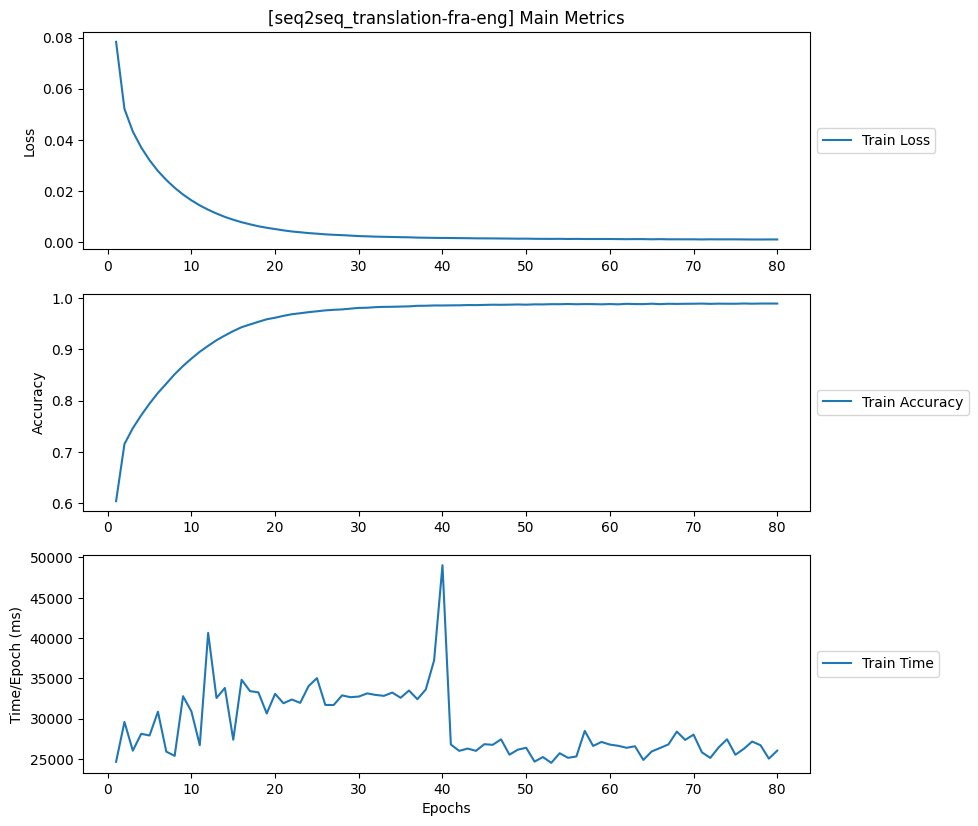

In [16]:
manager.train(epochs=80)

In [17]:
def evaluate_randomly(n=10):
    for _ in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = manager.evaluate(pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

evaluate_randomly()

> il se plaint tout le temps
= he is always complaining
< he is always complaining <EOS>

> je suis consciencieux
= i m thorough
< i m thorough <EOS>

> je suis mediocre au tennis
= i am poor at tennis
< i am poor at tennis <EOS>

> je ne suis pas autorisee a t aider
= i m not allowed to help you
< i m not allowed to help you <EOS>

> je nourris mon bebe au sein
= i m breast feeding my baby
< i m breast feeding my baby <EOS>

> je suis plutot bon en maths
= i m pretty good at math
< i m pretty good at math <EOS>

> je ne vais pas t epouser
= i m not marrying you
< i m not marrying you <EOS>

> vous n etes pas contrariees si ?
= you re not upset are you ?
< you re not upset are you ? <EOS>

> vous me faites marcher
= you re pulling my leg
< you re kidding you re kidding <EOS>

> je suis desole si mes paroles te blessent
= i m sorry if my words hurt you
< i m sorry if my words hurt you <EOS>



input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


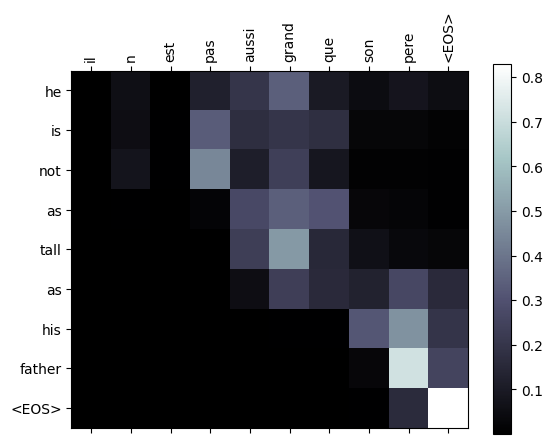

input = je suis trop fatigue pour conduire
output = i m too tired to drive to drive tomorrow <EOS>


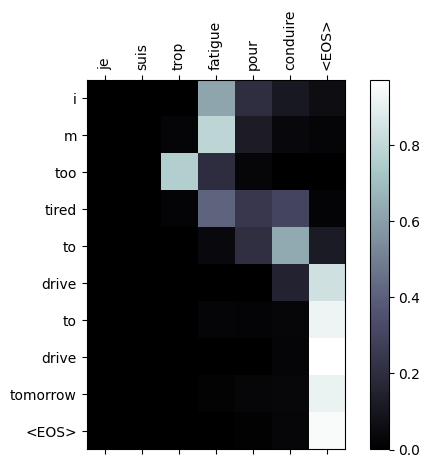

input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


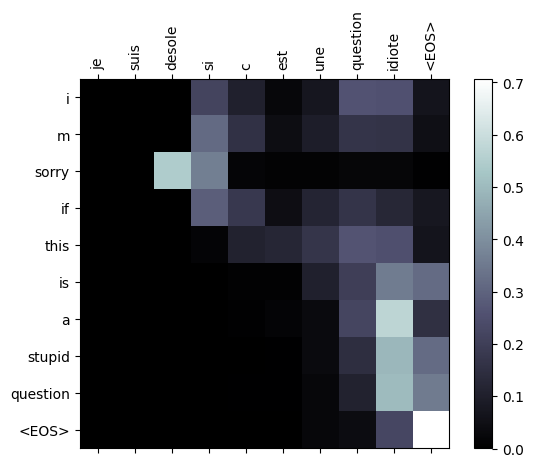

input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


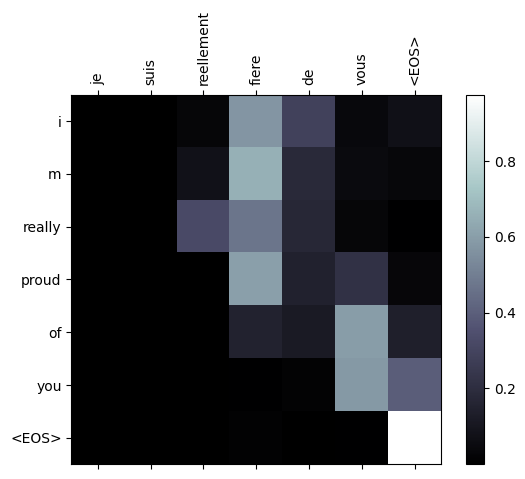

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def show_attention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluate_and_show_attention(input_sentence: str):
    output_words, attentions = manager.evaluate(input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions[0, :len(output_words), :])

if REVERSE:
    evaluate_and_show_attention('il n est pas aussi grand que son pere')
    evaluate_and_show_attention('je suis trop fatigue pour conduire')
    evaluate_and_show_attention('je suis desole si c est une question idiote')
    evaluate_and_show_attention('je suis reellement fiere de vous')
else:
    evaluate_and_show_attention('he is not as tall as his father')
    evaluate_and_show_attention('i am too tired to drive')
    evaluate_and_show_attention('i am sorry if this is a stupid question')
    evaluate_and_show_attention('i am really proud of you')